<a href="https://www.bigdatauniversity.com"><img src = "https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DA0101EN/Images/CCLog.png" width = 300, align = "center"></a>

## Advanced Data Science Capstone Project <cr>
### Time Series Forecasting with the Long Short-Term Memory Network in Python
### by Pablo César López

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

A pharmaceutical company needs to build rolling forecast models of product sales based on hitorical data. The approach we're going to follow is developing a ML model with historical data to forecasting the next 12 months for one specifict market, in this case, aspirine molecule (acetylsalicylic acid).

We proceed to import necessary libraries:

In [1]:
#Import libraries 

import pandas as pd
import pyodbc
import numpy as np
import matplotlib as plt
import seaborn as sns
import csv
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from datetime import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy

%matplotlib inline
%load_ext sql

Checking available driver for SQL SERVER:

In [2]:
pyodbc.drivers()

['ODBC Driver 17 for SQL Server']

Preparing ODBC conection:

## Data <a name="data"></a>

Historical Sales Data is stored in SQL SERVER Database. We're going to get only necessary data for prototype ML model for one market (melecule). If the result is positive, then we're going to scale to all data to all molecules contained in data base. We will delimite the scope to 7 years.

In [3]:
server = 'tcp:192.168.15.28,1433'
database = 'mfp_db'
username = 'usr_stg'
password = 'userstg'
cnxn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()

Collectiong data and exporting it to a csv file:

In [4]:
import pandas as pd #aspirine market from 201401 to 202004
query = '''

select sales_date, mth_sellout
from sales_tbl
where molecule='aspirine' and
sales_date>='2014-01-01'
order by sales_date

''';
df_aspirine = pd.read_sql(query, cnxn)
df_aspirine.to_csv("aspirine-sales.csv", index=False)
df_aspirine.head()

,sales_date,mth_sellout
0,2014-01-31,1.248197e+06
1,2014-02-28,1.158479e+06
2,2014-03-31,1.315807e+06
3,2014-04-30,1.275526e+06
4,2014-05-31,1.266350e+06


In [5]:
df_aspirine['mth_sellout'].describe()

count    7.600000e+01
mean     1.309687e+06
std      1.045167e+05
min      1.082200e+06
25%      1.243671e+06
50%      1.308538e+06
75%      1.372657e+06
max      1.533000e+06
Name: mth_sellout, dtype: float64

In [6]:
df_aspirine.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76 entries, 0 to 75
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   sales_date   76 non-null     object 
 1   mth_sellout  76 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.3+ KB


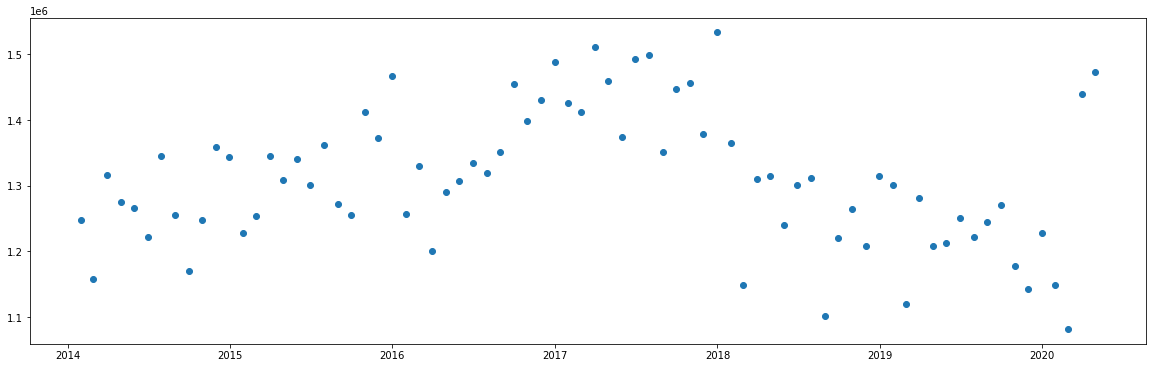

In [8]:
dates = plt.dates.date2num(df_aspirine['sales_date'])
plt.pyplot.plot_date(dates, df_aspirine['mth_sellout'])
plt.rcParams["figure.figsize"] = (20,6)
plt.pyplot.savefig('aspirine-sales.png')
plt.pyplot.show()

## Methodology <a name="methodology"></a>
We're going to use LSTM for building ML model to forecasting 12 months of sales with some custom functions:

## Analysis <a name="analysis"></a>

Building functions and model to forecasting next 12 values:

In [9]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = concat(columns, axis=1)
	df.fillna(0, inplace=True)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
	# fit scaler
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaler = scaler.fit(train)
	# transform train
	train = train.reshape(train.shape[0], train.shape[1])
	train_scaled = scaler.transform(train)
	# transform test
	test = test.reshape(test.shape[0], test.shape[1])
	test_scaled = scaler.transform(test)
	return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
	new_row = [x for x in X] + [value]
	array = numpy.array(new_row)
	array = array.reshape(1, len(array))
	inverted = scaler.inverse_transform(array)
	return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
	X, y = train[:, 0:-1], train[:, -1]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	model = Sequential()
	model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(1))
	model.compile(loss='mean_squared_error', optimizer='adam')
	for i in range(nb_epoch):
		model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
		model.reset_states()
	return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
	X = X.reshape(1, 1, len(X))
	yhat = model.predict(X, batch_size=batch_size)
	return yhat[0,0]

# load dataset
series = read_csv('aspirine-sales.csv', header=0, parse_dates=[0], index_col=0, squeeze=True)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
train, test = supervised_values[0:-12], supervised_values[-12:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 32)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
print("the LSTM model is ready") #we wait until model is ready! . . . . . . . Finally

the LSTM model is ready


## Results and Discussion <a name="results"></a>

We proceed to run the model to generate predicted values in order to compare with expected values:

In [10]:
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
	# make one-step forecast
	X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
	yhat = forecast_lstm(lstm_model, 1, X)
	# invert scaling
	yhat = invert_scale(scaler, X, yhat)
	# invert differencing
	yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
	# store forecast
	predictions.append(yhat)
	expected = raw_values[len(train) + i + 1]
	print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

Month=1, Predicted=1090873.961812, Expected=1213640.064000
Month=2, Predicted=1187758.546063, Expected=1251163.872000
Month=3, Predicted=1198005.289045, Expected=1222542.720000
Month=4, Predicted=1253009.101705, Expected=1244846.736000
Month=5, Predicted=1276887.522830, Expected=1270313.856000
Month=6, Predicted=1150345.005560, Expected=1178102.016000
Month=7, Predicted=1238868.713154, Expected=1143648.576000
Month=8, Predicted=1348224.682481, Expected=1227607.920000
Month=9, Predicted=1244072.010502, Expected=1149415.344000
Month=10, Predicted=1193446.267455, Expected=1082199.888000
Month=11, Predicted=1259222.919657, Expected=1439480.448000
Month=12, Predicted=1482308.694775, Expected=1472877.504000


Then we proceed to evaluate the RMSE in order to measure the error between predicted and expected values:

Test RMSE: 90418.826


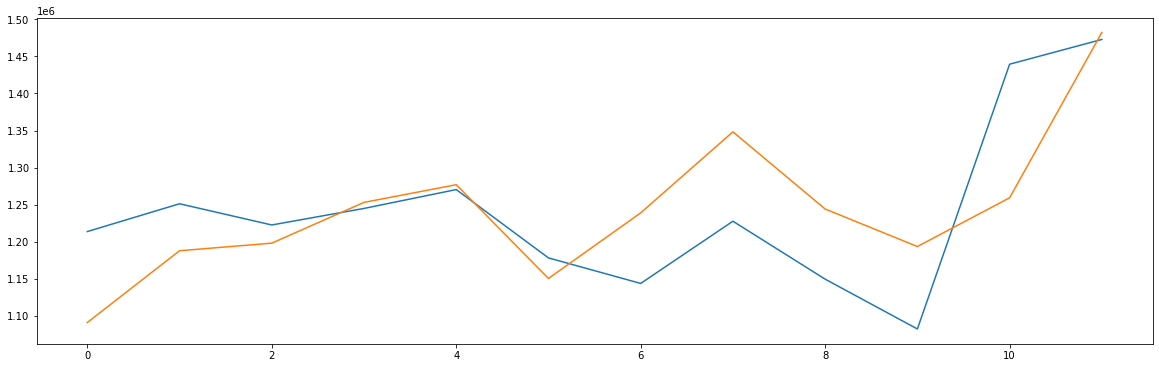

In [11]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(raw_values[-12:])
pyplot.plot(predictions)
pyplot.show()

# Conclusion <a name="conclusion"></a>

After evaluate ML model, error percentage is high. Feature engineering will be required to increase precision in order to proceed to build models for all markets in the data.